# CNN para reconocimiento de emociones con Tranfer Learning


Integrantes:

Fernando Jose Figueroa Olivo 3103133

Pamela Beatriz Gomez Rosales 3103132

Diego Jose Viana Landaverde 3103134

Obtención del dataset desde Kaggle: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data

El dataset esta compuesto de 8 carpetas etiquetadas con el nombre de la emoción y un archivo .csv que contiene los labels.

Anger

Contempt

Disgust

Fear

Happy

Neutral

Sad

Surprise

### Cargar el dataset (AffectNet)




In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

100%|██████████| 314M/314M [00:15<00:00, 21.6MB/s]

Extracting files...


## Definir las constantes e importar las dependecias

In [2]:
IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 8

In [3]:
import tensorflow as tf
import json
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Obtener los datos

In [4]:
# Cargar el archivo CSV con las rutas de las imágenes y sus etiquetas
csv_path = os.path.join(path, 'labels.csv')  # Asegúrate de poner la ruta correcta del archivo CSV
df = pd.read_csv(csv_path)

# Crear un diccionario que mapea las emociones a índices numéricos
emotion_dict = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6,
    'contempt': 7
}

# Limitar a 2000 imágenes por categoría
filtered_df = df.groupby('label').head(2000)

# Extraer las rutas de las imágenes y las etiquetas después del filtrado
image_paths = filtered_df['pth'].values  # Esto contiene las rutas de las imágenes
labels = filtered_df['label'].values  # Esto contiene los labels de las imágenes

# Convertir las etiquetas textuales a números usando el diccionario
labels_numeric = np.array([emotion_dict[label] for label in labels])

# Definir una función para cargar las imágenes
def load_image(image_path):
    # Cargar la imagen desde el path y convertirla a un array de numpy
    img = Image.open(image_path)
    #img = img.resize((96, 96))  # Cambia el tamaño según sea necesario
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    return img

# Cargar todas las imágenes limitadas a 2000 por categoría
x_data = np.array([load_image(os.path.join(path, img_path)) for img_path in image_paths])

# Normalizar las imágenes a un rango [0, 1]
x_data = x_data / 255.0

# Convertir las etiquetas a formato categórico
y_data = to_categorical(labels_numeric)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## Utilizar el ImageDataGenerator

In [5]:
# Aplicamos el aumento de datos al conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustamos el generador para los datos de entrenamiento
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

## Model V5

In [ ]:
INPUT_SHAPE = X_train.shape[1:]
def create_model_v5():
    # Cargar el modelo MobileNetV2 sin la parte superior (classification head)
    base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

    # Descongelar más capas del modelo base
    for layer in base_model.layers[:30]:  # Congelar las primeras 30 capas
        layer.trainable = False
    for layer in base_model.layers[30:]:  # Descongelar las capas superiores
        layer.trainable = True

    # Transfer learning: Usamos la salida de la penúltima capa del modelo base
    base_input = base_model.input
    base_output = base_model.output

    # Usamos GlobalAveragePooling2D para reducir la dimensionalidad
    x = tf.keras.layers.GlobalAveragePooling2D()(base_output)

    # Añadimos BatchNormalization y capas densas con regularización
    x = tf.keras.layers.BatchNormalization()(x)  # Añadir BatchNormalization para mejorar la convergencia
    x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Aumentamos las unidades
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Aumento del Dropout para evitar el sobreajuste

    x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    final_output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # Creamos el modelo final
    model_v5 = tf.keras.Model(inputs=base_input, outputs=final_output)

    return model_v5

# Paso 2: Compilar el modelo

In [7]:
def compile_model(model, X_train, y_train, X_test, y_test):

    # Definir el optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Definir los callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Paso 2.5 compilar el modelo
    model_history = model.fit(
        train_generator,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, reduce_lr]
    )

    return model_history

# Paso 4: Evaluar el modelo

In [8]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {test_accuracy:.4f}')

# Paso 5: Plot training history

In [9]:
def plot_training_history(model_history):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Paso 6: Guardar el modelo


In [11]:
def save_model(model, model_path):
    model.save(model_path)
    print(f'Model saved to {model_path}')

# Paso 7: Correr el codigo


In [12]:
# Create and compile the model
model_v5 = create_model_v5()
model_history = compile_model(model_v5, X_train, y_train, X_test, y_test)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 117ms/step - accuracy: 0.2264 - loss: 7.2183 - val_accuracy: 0.4078 - val_loss: 3.4739 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.4217 - loss: 2.8312 - val_accuracy: 0.3725 - val_loss: 3.1235 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.5052 - loss: 1.7721 - val_accuracy: 0.3300 - val_loss: 3.0486 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.5254 - loss: 1.5403 - val_accuracy: 0.5594 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - accuracy: 0.5569 - loss: 1.4474 - val_accuracy: 0.6037 - val_loss: 1.3819 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.5716 - loss: 1.4120 - val_accuracy: 0.5691 - val_loss: 1.7796 - learning_rate: 0.0010
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.5638 - loss

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7238 - loss: 0.8410
Test loss: 0.8718
Test accuracy: 0.7050


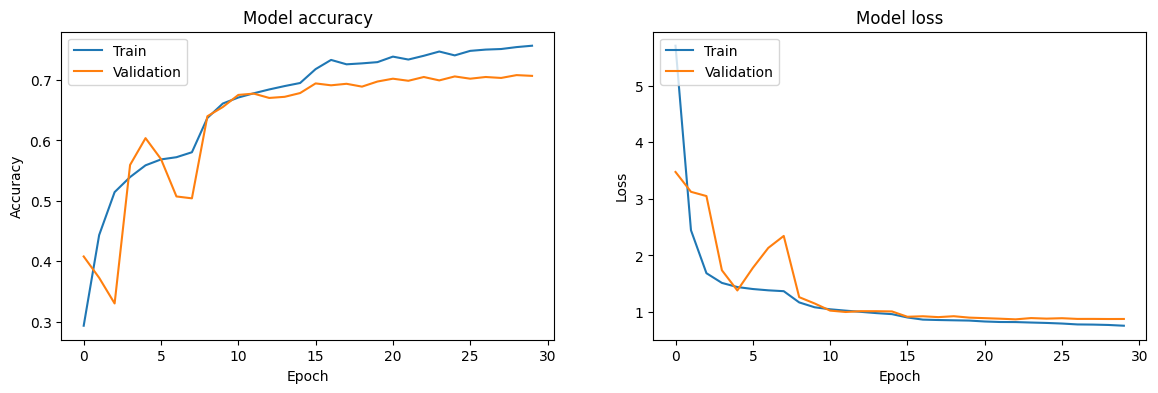

In [13]:
# Evaluate and plot the model
evaluate_model(model_v5, X_test, y_test)
plot_training_history(model_history)

In [14]:
# Plto confusion matrix and classification report
#plot_confusion_matrix(model_v2, X_test, y_test)
plot_classification_report(model_v5, X_test, y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

       anger       0.73      0.63      0.68       385
     disgust       0.74      0.65      0.69       420
        fear       0.70      0.82      0.76       443
       happy       0.83      0.91      0.87       403
         sad       0.64      0.59      0.62       386
    surprise       0.66      0.51      0.58       388
     neutral       0.56      0.76      0.65       359
    contempt       0.78      0.75      0.77       416

    accuracy                           0.70      3200
   macro avg       0.71      0.70      0.70      3200
weighted avg       0.71      0.70      0.70      3200



100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


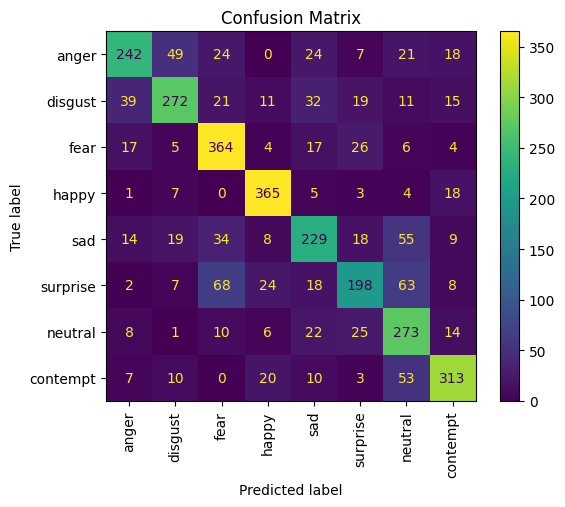

In [15]:
def plot_confusion_matrix(model, x_test, y_test, class_names):
    """
    Genera e imprime la matriz de confusión para un modelo dado.

    Args:
        model: El modelo entrenado de TensorFlow/Keras.
        x_test: Datos de prueba (imágenes).
        y_test: Etiquetas de prueba en formato one-hot.
        class_names: Lista de nombres de las clases (emociones).
    """
    # Convertir etiquetas reales (y_test) de one-hot a enteros
    if y_test.ndim > 1:  # Si las etiquetas están en formato one-hot
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    # Obtener predicciones del modelo y convertir a etiquetas enteras
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Lista de nombres de las clases
class_names = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'contempt']

# Llamar a la función para mostrar la matriz de confusión
plot_confusion_matrix(model_v5, X_test, y_test, class_names)

In [17]:
# Save the model
model_path = 'emotion_recognition_model.keras'
save_model(model_v5, model_path)

Model saved to emotion_recognition_model.keras
